### Introduction
Briefly describe the project, its objectives, and the dataset you will use.

### Setup and Imports
Import necessary libraries (`tensorflow`, `numpy`, `matplotlib`, etc.).

In [135]:
'''Setup and Imports'''
import numpy as np
import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# If the warning persists, you might try using the legacy optimizer as follows:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Add, Multiply, DepthwiseConv2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import layers, models # for defining the generator and discriminator networks
from tensorflow.keras.activations import swish
from tensorflow.keras import backend as K
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization
from PIL import Image # for loading images
import matplotlib.image as mpimg # for loading images
import matplotlib.pyplot as plt
import pandas as pd # for data visualization
import sklearn # for any additional machine learning utilities
from sklearn.preprocessing import MultiLabelBinarizer # for one-hot encoding of ingredient labels
from sklearn.model_selection import train_test_split # for splitting the dataset
import skimage # for image processing
from skimage.transform import resize
from skimage.io import imread
import os

### Dataset Loading and Preprocessing
- Load your dataset of smoothie images.
- Preprocess images (resizing, normalization).
- Split the dataset into training and testing sets.

This code combines loading, preprocessing, encoding, and splitting into a single cell, ensuring that `X_train`, `X_val`, `y_train`, and `y_val` are properly defined and available for training and validation.

In [136]:
'''Dataset Loading and Preprocessing'''
# Define the path to your JSON file
# dataset_path = 'datasets/smoothies.json'
file_path = '/Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/smoothie-cGAN/datasets/datasets/smoothies.json'

# Load the dataset
dataset = pd.read_json(file_path)

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Ensure the full path is correctly constructed from the notebook's location
    full_image_path = os.path.abspath(image_path)
    try:
        with Image.open(full_image_path) as img:
            # Rest of your preprocessing code here
            img = img.convert('RGBA')  # Convert to RGBA to handle transparency
            canvas = Image.new('RGBA', img.size, "WHITE")  # Create a white canvas
            canvas.paste(img, mask=img.split()[3])  # Paste using alpha channel as mask
            img = canvas.convert('RGB')  # Convert back to RGB
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except IOError as e:
        print(f"Error opening or processing image {full_image_path}: {e}")
        return None

# Correctly update image paths relative to the notebook's current directory
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and convert them into an array X
# Ensure that only existing paths are passed to the preprocessing function
X = np.array(dataset['image'].apply(preprocess_image).tolist())

# Encode ingredient labels
unique_ingredients = set(item for sublist in dataset['ingredients'] for item in sublist)
mlb = MultiLabelBinarizer(classes=sorted(unique_ingredients))
y = mlb.fit_transform(dataset['ingredients'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

image_shape = (128, 128, 3)  # After preprocessing images
num_tags = y.shape[1]  # Number of unique tags

### Data Augmentation
- Implement data augmentation techniques to diversify your training dataset and improve model robustness.

In [137]:
'''Data Augmentation'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=20,      # Random rotations. Random rotation between 0 and 10 degrees. Used to be 10
    width_shift_range=0.2,  # Random horizontal shifts. Fraction of total width for horizontal shift. Used to be 0.1
    height_shift_range=0.2, # Random vertical shifts. Fraction of total height for vertical shift. Used to be 0.1
    shear_range=0.15,        # Shear transformations. Used to be 0.1
    zoom_range=0.2,         # Random zoom. Random zoom between 90% (0.9) and 110% (1.1). Used to be 0.1
    channel_shift_range=30, # Add channel shifting for color variation
    vertical_flip=True,     # Add vertical flips for more variability
    horizontal_flip=True,   # Horizontal flips. Randomly flip inputs horizontally. 
    fill_mode='reflect'     # Fill strategy. Strategy for filling in newly created pixels. Used to be nearest
)

### Model 
- Define the diffusion model architecture. This can be challenging without specific code examples for diffusion models, as they are complex and involve nuanced implementation details. You might start with simpler generative models to gain more experience.
In a diffusion model, you typically need two main components: the model that predicts the noise (often a U-Net architecture for images), and the diffusion process itself which involves a series of forward (noising) and reverse (denoising) steps.
- U-Net Architecture for Images: This CNN architecture is effective for tasks that require understanding the context of the entire image, such as generating or denoising images. It consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

```python
'''Model Architecture'''
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    
    # Upsample
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same')(u4)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same')(u5)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Output layer
    output = Conv2D(3, (1, 1), activation='tanh')(c5)
    
    return Model(inputs=inputs, outputs=output)
```

In [138]:
'''Model Architecture'''
def unet_model_advanced(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Example of an advanced block with attention and residual connection
    def residual_attention_block(x, filters):
        # Residual connection
        residual = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
        
        # Main path
        main = Conv2D(filters, (3, 3), padding='same')(x)
        main = Activation(swish)(main)
        
        # Attention mechanism
        attn = GlobalAveragePooling2D()(main)
        attn = Reshape((1, 1, filters))(attn)
        attn = Conv2D(filters, (1, 1), activation='sigmoid')(attn)
        main = Multiply()([main, attn])
        
        # Combining paths
        out = Add()([residual, main])
        return out

    # Downsample
    c1 = residual_attention_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_attention_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = residual_attention_block(p2, 64)
    
    # Upsample
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same')(u4)
    u4 = concatenate([u4, c2])
    c4 = residual_attention_block(u4, 32)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same')(u5)
    u5 = concatenate([u5, c1], axis=3)
    c5 = residual_attention_block(u5, 16)
    
    # Output layer
    output = Conv2D(3, (1, 1), activation='tanh')(c5)
    
    return Model(inputs=inputs, outputs=output)

# Re-instantiate and compile the model with the advanced architecture
model = unet_model_advanced(input_size=(128, 128, 3))
model.compile(optimizer=Adam(learning_rate=7e-4), loss=MeanSquaredError())


### Training Setup
- Define the loss functions, optimizers, and training loop.
- Implement the forward and reverse processes of the diffusion model.

Implemented in the following cell:
- Diffusion Process: involves defining the forward process (adding noise) and the reverse process (model learning to reverse the noising process)
- Loss Function: a mean squared error (MSE) between the original images and the reconstructed images
- Optimizer: Adam optimizer

In [139]:
'''Training Setup'''
# Assuming 'unet_model' is your U-Net model function from the previous cell
model = unet_model(input_size=(128, 128, 3))

# Loss function
loss_function = MeanSquaredError()

# Optimizer
optimizer = Adam(learning_rate=7e-4) # used to be `1e-4` (0.0001)

model.compile(optimizer=optimizer, loss=loss_function)

# Forward process - Adding noise
def add_noise(images, noise_factor=0.1):
    """
    Adds Gaussian noise to each image.
    """
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, -1.0, 1.0)  # Ensure the images are still in [-1, 1]
    return noisy_images

# Reverse process - This is implicitly learned by the model during training
# by trying to reconstruct the original images from the noisy images.



### Training Execution
- Run the training loop, periodically saving generated images to monitor progress.

Inluced in the following cell:
- Iterate over epochs
- In each epoch, run the forward diffusion process to add noise to the images, then run the reverse process where the model learns to reconstruct the original images from the noised images
- Update the model weights based on the loss between the reconstructed images and the original images

This code snippet includes the training loop where:
- Noise is added to the original images to simulate the forward diffusion process.
- The model learns to reconstruct the original images from their noisy counterparts.
- Training loss is recorded and printed at the end of each epoch.
- Sample images (original, noisy, and reconstructed) are displayed at specified intervals to visually assess the model's performance.
- Training loss is plotted over epochs to visualize the learning progress.

2024-03-03 07:28:48.305910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:49.259834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 1, Loss: 0.431903138756752


2024-03-03 07:28:49.894648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:50.533135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 2, Loss: 0.11761193722486496


2024-03-03 07:28:51.152832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:51.782272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 3, Loss: 0.11975720152258873


2024-03-03 07:28:52.364813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:52.935196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 4, Loss: 0.11586609855294228


2024-03-03 07:28:53.594449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:54.247413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 5, Loss: 0.10417209565639496


2024-03-03 07:28:54.892329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:55.503621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 6, Loss: 0.10433963313698769


2024-03-03 07:28:56.124881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:56.738396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 7, Loss: 0.07510929927229881


2024-03-03 07:28:57.487423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:58.147749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 8, Loss: 0.0555278230458498


2024-03-03 07:28:58.775386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:28:59.431130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 9, Loss: 0.04466438852250576


2024-03-03 07:29:00.058518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:00.700671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 10, Loss: 0.04546975530683994
1/1 [==============================] - 0s 223ms/step


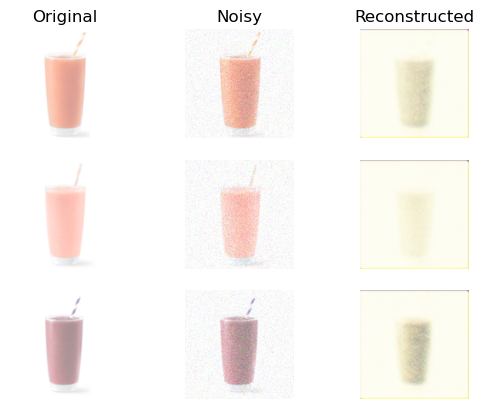

2024-03-03 07:29:01.714757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:02.386530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 11, Loss: 0.04732945375144482


2024-03-03 07:29:02.958499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:03.515773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 12, Loss: 0.034938786178827286


2024-03-03 07:29:04.073449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:04.705190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 13, Loss: 0.03654563054442406


2024-03-03 07:29:05.321592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:05.955489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 14, Loss: 0.03424536809325218


2024-03-03 07:29:06.550461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:07.152414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 15, Loss: 0.02971588633954525


2024-03-03 07:29:07.763384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:08.368399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 16, Loss: 0.03230626694858074


2024-03-03 07:29:08.943310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:09.525051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 17, Loss: 0.030298531986773014


2024-03-03 07:29:10.111545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:10.673425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 18, Loss: 0.02625037170946598


2024-03-03 07:29:11.314291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:11.883016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 19, Loss: 0.02660256437957287


2024-03-03 07:29:12.455042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:13.146111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 20, Loss: 0.02371021080762148
1/1 [==============================] - 0s 282ms/step


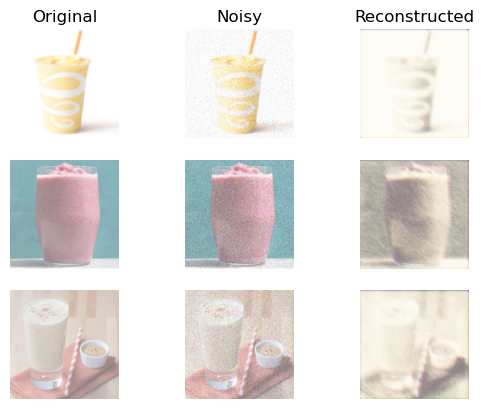

2024-03-03 07:29:14.248087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:14.912335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 21, Loss: 0.02500257547944784


2024-03-03 07:29:15.520024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:16.229252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 22, Loss: 0.02499159425497055


2024-03-03 07:29:16.863175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:17.445424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 23, Loss: 0.022402869537472725


2024-03-03 07:29:18.028026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:18.587379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 24, Loss: 0.021389193832874298


2024-03-03 07:29:19.142215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:19.725544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 25, Loss: 0.02475171722471714


2024-03-03 07:29:20.308915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:20.883109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 26, Loss: 0.022315976209938526


2024-03-03 07:29:21.467597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:22.037212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 27, Loss: 0.021442076191306114


2024-03-03 07:29:22.613486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:23.182977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 28, Loss: 0.020092044956982136


2024-03-03 07:29:23.742188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:24.381849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 29, Loss: 0.02217841800302267


2024-03-03 07:29:24.955499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:25.510807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 30, Loss: 0.020370585843920708
1/1 [==============================] - 0s 164ms/step


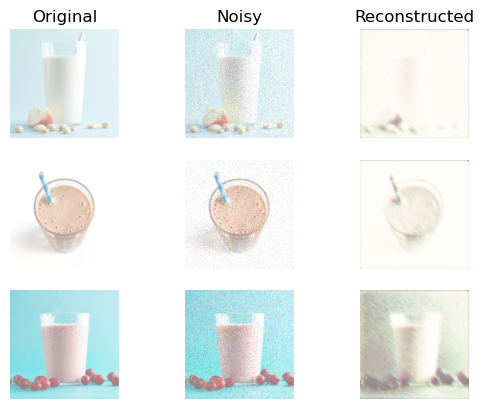

2024-03-03 07:29:26.511432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:27.092035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 31, Loss: 0.020525222644209862


2024-03-03 07:29:27.683285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:28.259166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 32, Loss: 0.017336015589535236


2024-03-03 07:29:28.847581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:29.448459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 33, Loss: 0.018450358882546425


2024-03-03 07:29:30.132047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:30.836573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 34, Loss: 0.01815427653491497


2024-03-03 07:29:31.424266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:32.004729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 35, Loss: 0.015879256650805473


2024-03-03 07:29:32.565500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:33.156400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 36, Loss: 0.017040754668414593


2024-03-03 07:29:33.721412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:34.301268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 37, Loss: 0.014871971681714058


2024-03-03 07:29:34.884705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:35.460150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 38, Loss: 0.013823636807501316


2024-03-03 07:29:36.054108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:36.616562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 39, Loss: 0.016105478163808584


2024-03-03 07:29:37.289237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:37.852059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 40, Loss: 0.014519224874675274
1/1 [==============================] - 0s 176ms/step


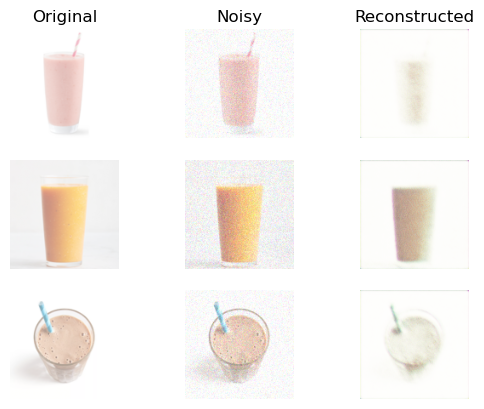

2024-03-03 07:29:38.783621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:39.360097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 41, Loss: 0.012290253769606352


2024-03-03 07:29:39.927613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:40.515221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 42, Loss: 0.012728042900562286


2024-03-03 07:29:41.109519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:41.680142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 43, Loss: 0.013923583552241325


2024-03-03 07:29:42.244379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:42.823389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 44, Loss: 0.011910289525985718


2024-03-03 07:29:43.388762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:43.973629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 45, Loss: 0.012610911391675472


2024-03-03 07:29:44.585447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:45.240756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 46, Loss: 0.01098871324211359


2024-03-03 07:29:45.924107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:46.561316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 47, Loss: 0.011833693832159042


2024-03-03 07:29:47.153460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:47.753722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 48, Loss: 0.011929820291697979


2024-03-03 07:29:48.359340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:49.028317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 49, Loss: 0.010645484551787376


2024-03-03 07:29:49.651903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:50.308147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 50, Loss: 0.009452028200030327
1/1 [==============================] - 0s 173ms/step


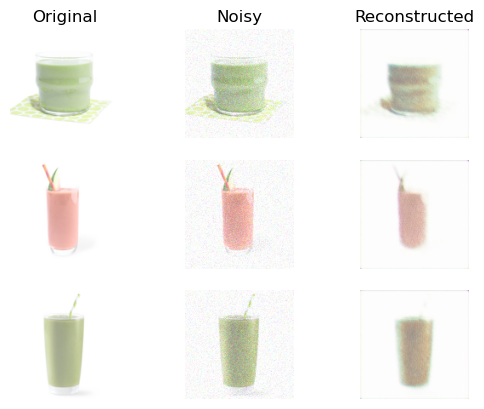

2024-03-03 07:29:51.231388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:51.909417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 51, Loss: 0.010454126633703709


2024-03-03 07:29:52.529790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:53.147524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 52, Loss: 0.008986310567706823


2024-03-03 07:29:53.790326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:54.381493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 53, Loss: 0.009590854868292809


2024-03-03 07:29:54.991139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:55.615173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 54, Loss: 0.010994666256010532


2024-03-03 07:29:56.185875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:56.752195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 55, Loss: 0.009585242718458176


2024-03-03 07:29:57.471664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:58.211715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 56, Loss: 0.009718360379338264


2024-03-03 07:29:58.862217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:29:59.475235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 57, Loss: 0.00942659704014659


2024-03-03 07:30:00.183974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:00.797987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 58, Loss: 0.008688097354024649


2024-03-03 07:30:01.490847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:02.170268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 59, Loss: 0.008916788268834352


2024-03-03 07:30:02.825727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:03.451701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 60, Loss: 0.008587200660258532
1/1 [==============================] - 0s 156ms/step


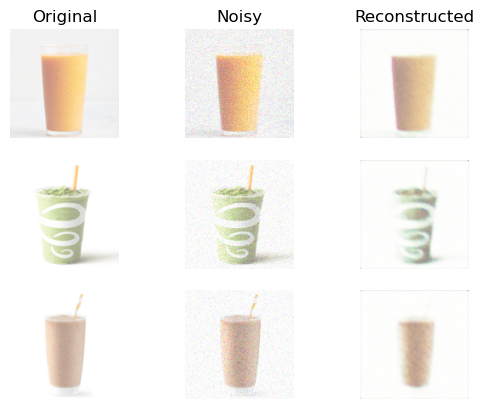

2024-03-03 07:30:04.385135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:04.985345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 61, Loss: 0.008345732931047678


2024-03-03 07:30:05.555222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:06.183053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 62, Loss: 0.008897236315533519


2024-03-03 07:30:06.796821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:07.401308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 63, Loss: 0.007874084636569023


2024-03-03 07:30:07.973630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:08.542868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 64, Loss: 0.007322702324017882


2024-03-03 07:30:09.152874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:09.739055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 65, Loss: 0.007918634684756398


2024-03-03 07:30:10.311276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:10.875440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 66, Loss: 0.007680634269490838


2024-03-03 07:30:11.585120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:12.313039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 67, Loss: 0.007281279424205422


2024-03-03 07:30:12.943576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:13.522915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 68, Loss: 0.007395242340862751


2024-03-03 07:30:14.260913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:14.877464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 69, Loss: 0.007617989555001259


2024-03-03 07:30:15.570468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:16.269400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 70, Loss: 0.006949970033019781
1/1 [==============================] - 0s 177ms/step


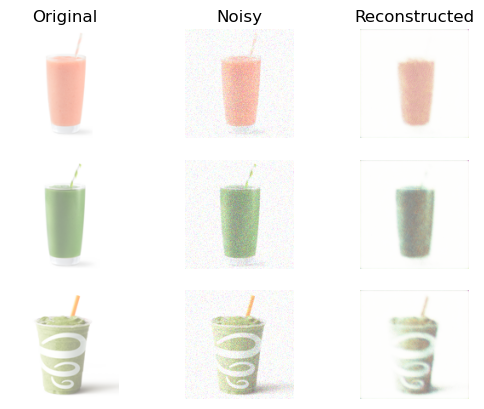

2024-03-03 07:30:17.496194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:18.221481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 71, Loss: 0.007118581561371684


2024-03-03 07:30:18.834196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:19.396458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 72, Loss: 0.007000811630859971


2024-03-03 07:30:20.053417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:20.675523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 73, Loss: 0.0073028982151299715


2024-03-03 07:30:21.263784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:21.851024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 74, Loss: 0.007352178916335106


2024-03-03 07:30:22.615226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:23.363241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 75, Loss: 0.00687884003855288


2024-03-03 07:30:23.931955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:24.555488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 76, Loss: 0.007103326031938195


2024-03-03 07:30:25.150381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:25.837927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 77, Loss: 0.006549803540110588


2024-03-03 07:30:26.470544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:27.067377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 78, Loss: 0.006505311466753483


2024-03-03 07:30:27.816612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:28.393883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 79, Loss: 0.006673845229670405


2024-03-03 07:30:28.974780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:29.542809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 80, Loss: 0.0066878458019346
1/1 [==============================] - 0s 170ms/step


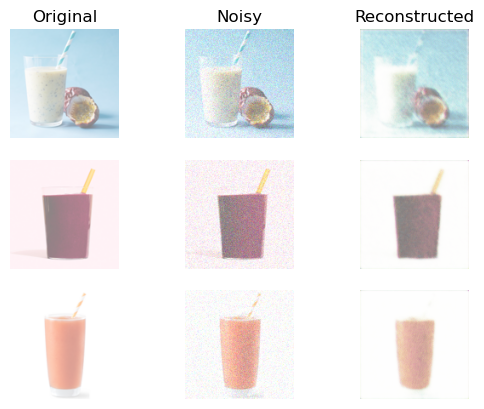

2024-03-03 07:30:30.503981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:31.096053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 81, Loss: 0.006081979721784592


2024-03-03 07:30:31.666929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:32.323318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 82, Loss: 0.0066082950215786695


2024-03-03 07:30:32.988087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:33.707358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 83, Loss: 0.005487390793859959


2024-03-03 07:30:34.396320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:35.003302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 84, Loss: 0.006119361147284508


2024-03-03 07:30:35.628098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:36.248936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 85, Loss: 0.006145065184682608


2024-03-03 07:30:36.879238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:37.528768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 86, Loss: 0.006492760730907321


2024-03-03 07:30:38.146464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:38.760010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 87, Loss: 0.005927676800638437


2024-03-03 07:30:39.375036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:39.950269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 88, Loss: 0.005564115010201931


2024-03-03 07:30:40.500874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:41.098620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 89, Loss: 0.005805677967146039


2024-03-03 07:30:41.675424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:42.236804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 90, Loss: 0.005383433774113655
1/1 [==============================] - 0s 156ms/step


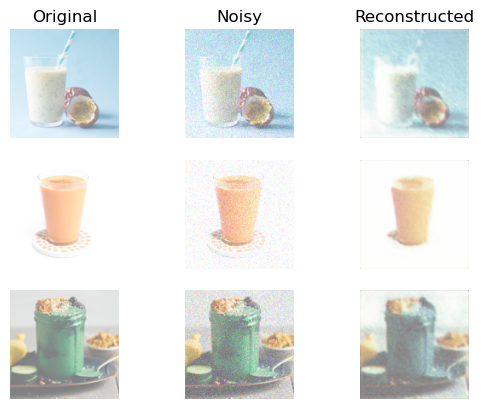

2024-03-03 07:30:43.122536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:43.694837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 91, Loss: 0.005866504739969969


2024-03-03 07:30:44.322980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:44.896383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 92, Loss: 0.006364226574078202


2024-03-03 07:30:45.464877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:46.039479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 93, Loss: 0.005791665520519018


2024-03-03 07:30:46.605673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:47.172173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 94, Loss: 0.0056502006482332945


2024-03-03 07:30:47.741826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:48.437751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 95, Loss: 0.0061461725272238255


2024-03-03 07:30:49.162610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:49.737376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 96, Loss: 0.005520302569493651


2024-03-03 07:30:50.492848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:51.102173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 97, Loss: 0.005620567360892892


2024-03-03 07:30:51.757360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:52.373879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 98, Loss: 0.005884565878659487


2024-03-03 07:30:53.014176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:53.665720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 99, Loss: 0.005161258624866605


2024-03-03 07:30:54.291895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:54.908131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 100, Loss: 0.005350261693820357
1/1 [==============================] - 0s 169ms/step


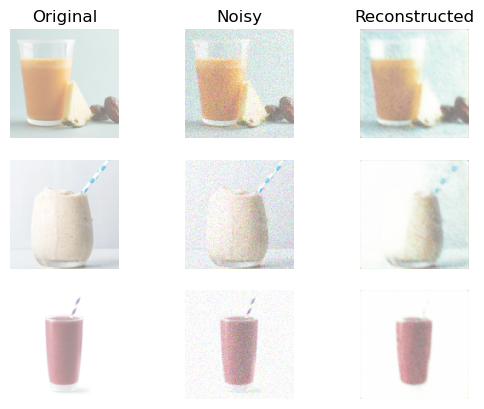

2024-03-03 07:30:55.853448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:56.474650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 101, Loss: 0.006087016547098756


2024-03-03 07:30:57.086731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:57.695741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 102, Loss: 0.005136486841365695


2024-03-03 07:30:58.294479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:30:58.902308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 103, Loss: 0.005295587470754981


2024-03-03 07:30:59.523285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:00.177105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 104, Loss: 0.005471261451020837


2024-03-03 07:31:00.742360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:01.302790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 105, Loss: 0.005452160956338048


2024-03-03 07:31:01.869747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:02.431911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 106, Loss: 0.005101712420582771


2024-03-03 07:31:03.035066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:03.639789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 107, Loss: 0.005333666689693928


2024-03-03 07:31:04.198785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:04.780447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 108, Loss: 0.005179424304515123


2024-03-03 07:31:05.341157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:05.923537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 109, Loss: 0.005689272424206138


2024-03-03 07:31:06.570103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:07.139623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 110, Loss: 0.005093903746455908
1/1 [==============================] - 0s 158ms/step


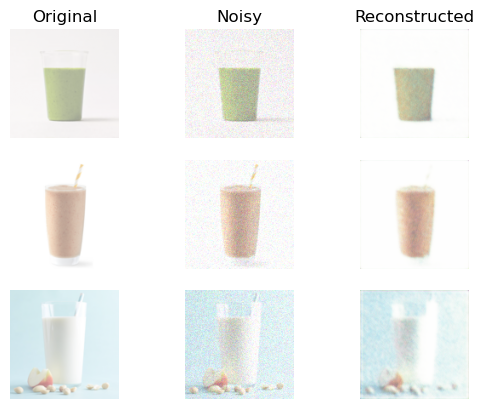

2024-03-03 07:31:08.022712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:08.609819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 111, Loss: 0.005096638109534979


2024-03-03 07:31:09.166641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:09.733683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 112, Loss: 0.005274909548461437


2024-03-03 07:31:10.289378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:10.881178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 113, Loss: 0.004832667298614979


2024-03-03 07:31:11.452826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:12.027402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 114, Loss: 0.005512421717867255


2024-03-03 07:31:12.609161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:13.180327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 115, Loss: 0.004784262040629983


2024-03-03 07:31:13.750741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:14.460101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 116, Loss: 0.004685940453782678


2024-03-03 07:31:15.193003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:15.827390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 117, Loss: 0.004767982754856348


2024-03-03 07:31:16.570668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:17.257929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 118, Loss: 0.004549024626612663


2024-03-03 07:31:17.896849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:18.514816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 119, Loss: 0.004905660869553685


2024-03-03 07:31:19.138202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:19.780377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 120, Loss: 0.004558673361316323
1/1 [==============================] - 0s 159ms/step


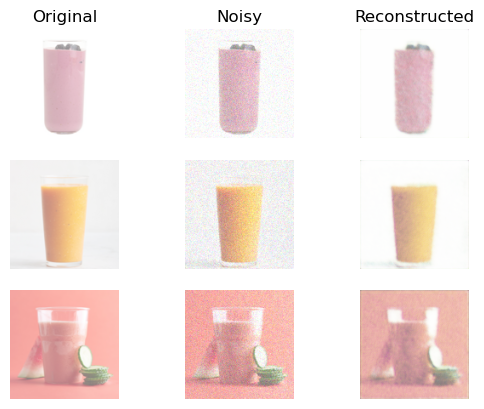

2024-03-03 07:31:20.753858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:21.360004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 121, Loss: 0.00435273558832705


2024-03-03 07:31:21.976972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:22.643691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 122, Loss: 0.00463878083974123


2024-03-03 07:31:23.205334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:23.773124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 123, Loss: 0.004721968434751034


2024-03-03 07:31:24.333038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:24.892863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 124, Loss: 0.004532698541879654


2024-03-03 07:31:25.454228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:26.012465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 125, Loss: 0.003941202186979353


2024-03-03 07:31:26.573901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:27.147799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 126, Loss: 0.004364390391856432


2024-03-03 07:31:27.715345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:28.328153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 127, Loss: 0.004197693429887295


2024-03-03 07:31:28.941999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:29.526039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 128, Loss: 0.004770495695993304


2024-03-03 07:31:30.089469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:30.659596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 129, Loss: 0.0045374236069619656


2024-03-03 07:31:31.273848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:31.880001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 130, Loss: 0.004295435734093189
1/1 [==============================] - 0s 168ms/step


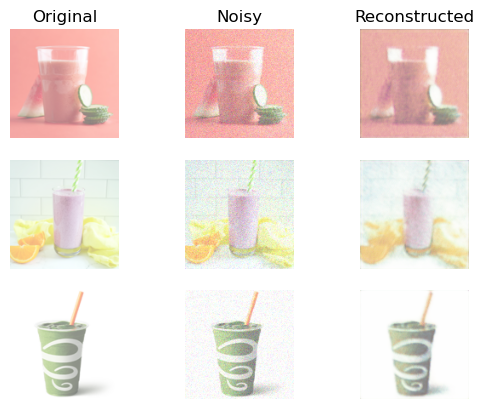

2024-03-03 07:31:32.818973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:33.521759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 131, Loss: 0.004539102781563997


2024-03-03 07:31:34.101119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:34.678123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 132, Loss: 0.00404873420484364


2024-03-03 07:31:35.250696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:35.827538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 133, Loss: 0.004490419756621122


2024-03-03 07:31:36.413248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:37.007105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 134, Loss: 0.00442807050421834


2024-03-03 07:31:37.571679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:38.186180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 135, Loss: 0.004328363109380007


2024-03-03 07:31:38.826593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:39.405317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 136, Loss: 0.004166380036622286


2024-03-03 07:31:39.994497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:40.558249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 137, Loss: 0.004017715458758175


2024-03-03 07:31:41.119254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:41.692244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 138, Loss: 0.004097050987184048


2024-03-03 07:31:42.255867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:42.829402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 139, Loss: 0.003588829538784921


2024-03-03 07:31:43.393377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:43.950315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 140, Loss: 0.003972889157012105
1/1 [==============================] - 0s 168ms/step


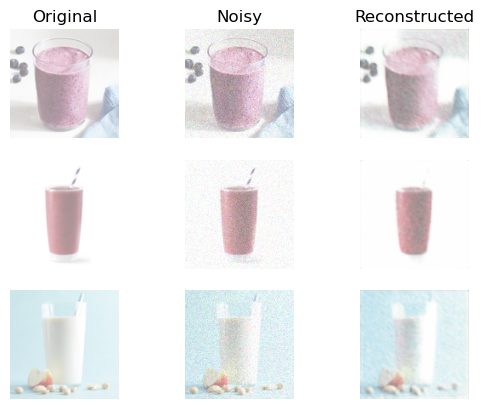

2024-03-03 07:31:44.879330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:45.512525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 141, Loss: 0.004549462581053376


2024-03-03 07:31:46.080624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:46.662301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 142, Loss: 0.004553350619971752


2024-03-03 07:31:47.264091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:47.883851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 143, Loss: 0.0038752545369789004


2024-03-03 07:31:48.459288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:49.025705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 144, Loss: 0.00415372708812356


2024-03-03 07:31:49.594423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:50.164858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 145, Loss: 0.003892993205226958


2024-03-03 07:31:50.727770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:51.327213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 146, Loss: 0.0039237975142896175


2024-03-03 07:31:51.934658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:52.517494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 147, Loss: 0.004470216343179345


2024-03-03 07:31:53.086751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:53.701435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 148, Loss: 0.004101654049009085


2024-03-03 07:31:54.484108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:55.227411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 149, Loss: 0.003710938268341124


2024-03-03 07:31:55.845890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:56.487660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 150, Loss: 0.003959999303333461
1/1 [==============================] - 0s 186ms/step


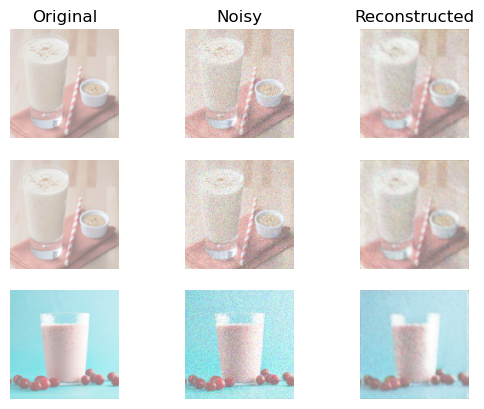

2024-03-03 07:31:57.493171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:58.138045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 151, Loss: 0.004395149415358901


2024-03-03 07:31:58.707354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:31:59.302354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 152, Loss: 0.003984938724897802


2024-03-03 07:31:59.892291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:00.533489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 153, Loss: 0.004157890100032091


2024-03-03 07:32:01.270335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:01.888082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 154, Loss: 0.004319753497838974


2024-03-03 07:32:02.506556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:03.102510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 155, Loss: 0.003984579583629966


2024-03-03 07:32:03.746556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:04.317666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 156, Loss: 0.003621490905061364


2024-03-03 07:32:04.894350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:05.453545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 157, Loss: 0.0037290678592398763


2024-03-03 07:32:06.026988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:06.606435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 158, Loss: 0.0037668622098863125


2024-03-03 07:32:07.276294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:07.855974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 159, Loss: 0.003816607524640858


2024-03-03 07:32:08.443422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:09.019563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 160, Loss: 0.004078008001670241
1/1 [==============================] - 0s 248ms/step


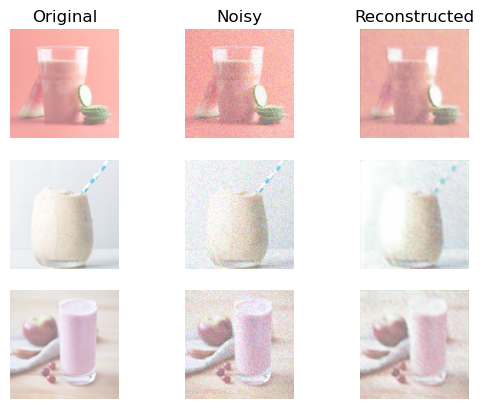

2024-03-03 07:32:10.630444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:11.352339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 161, Loss: 0.004076872020959854


2024-03-03 07:32:11.975073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:12.588277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 162, Loss: 0.004072361858561635


2024-03-03 07:32:13.168572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:13.750885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 163, Loss: 0.0038242072332650423


2024-03-03 07:32:14.433045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:15.114217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 164, Loss: 0.004306690534576774


2024-03-03 07:32:15.774093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:16.544607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 165, Loss: 0.003768039168789983


2024-03-03 07:32:17.164470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:17.731705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 166, Loss: 0.004114619689062238


2024-03-03 07:32:18.309434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:18.871168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 167, Loss: 0.0036007107701152563


2024-03-03 07:32:19.464283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:20.098511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 168, Loss: 0.003715996630489826


2024-03-03 07:32:20.666587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:21.231875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 169, Loss: 0.003967809025198221


2024-03-03 07:32:21.789741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:22.375934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 170, Loss: 0.004141252720728517
1/1 [==============================] - 0s 156ms/step


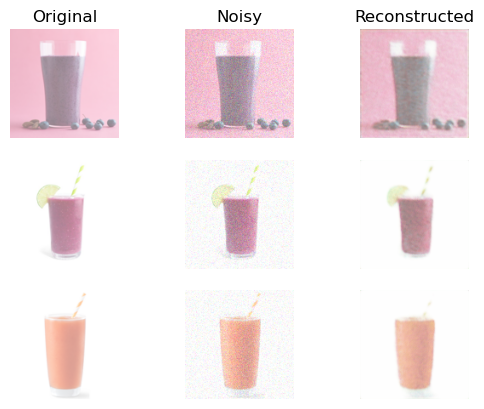

2024-03-03 07:32:23.282527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:23.889261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 171, Loss: 0.003471131785772741


2024-03-03 07:32:24.479762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:25.053655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 172, Loss: 0.0038252072408795357


2024-03-03 07:32:25.636056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:26.432253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 173, Loss: 0.003897707909345627


2024-03-03 07:32:27.193348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:27.795773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 174, Loss: 0.00389427924528718


2024-03-03 07:32:28.412996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:29.067737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 175, Loss: 0.003619641880504787


2024-03-03 07:32:29.695306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:30.297442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 176, Loss: 0.003671883372589946


2024-03-03 07:32:30.927861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:31.523763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 177, Loss: 0.003914525266736746


2024-03-03 07:32:32.122192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:32.698203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 178, Loss: 0.0041921609081327915


2024-03-03 07:32:33.268870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:33.835187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 179, Loss: 0.003396662068553269


2024-03-03 07:32:34.415414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:34.985167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 180, Loss: 0.0034458902664482594
1/1 [==============================] - 0s 158ms/step


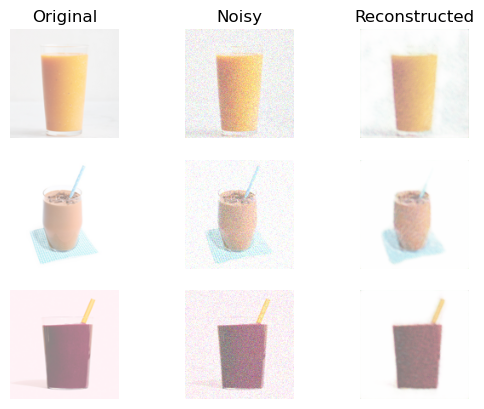

2024-03-03 07:32:35.883201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:36.456803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 181, Loss: 0.0032529584132134914


2024-03-03 07:32:37.075876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:37.658671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 182, Loss: 0.0036291127325966954


2024-03-03 07:32:38.220548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:38.795336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 183, Loss: 0.0032200434943661094


2024-03-03 07:32:39.367008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:40.135533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 184, Loss: 0.003354406915605068


2024-03-03 07:32:40.853531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:41.570382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 185, Loss: 0.003740955959074199


2024-03-03 07:32:42.302902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:42.952222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 186, Loss: 0.003532822127453983


2024-03-03 07:32:43.570988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:44.211964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 187, Loss: 0.003687901538796723


2024-03-03 07:32:44.805465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:45.409246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 188, Loss: 0.0035876960027962923


2024-03-03 07:32:45.970591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:46.573076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 189, Loss: 0.0032778631430119276


2024-03-03 07:32:47.183921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:47.829723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 190, Loss: 0.003254570998251438
1/1 [==============================] - 0s 158ms/step


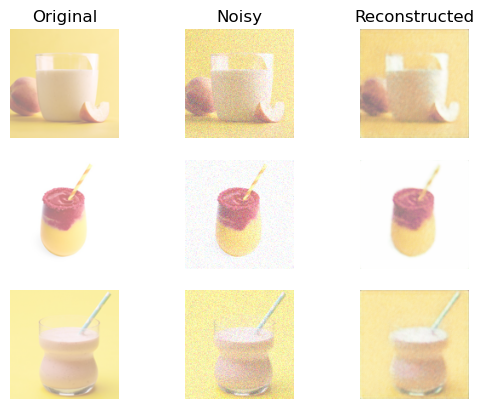

2024-03-03 07:32:48.769229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:49.345023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 191, Loss: 0.0033097612904384732


2024-03-03 07:32:49.920484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:50.553092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 192, Loss: 0.0035409015836194158


2024-03-03 07:32:51.172850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:51.779261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 193, Loss: 0.0033927769400179386


2024-03-03 07:32:52.393833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:52.950846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 194, Loss: 0.0031236893264576793


2024-03-03 07:32:53.518189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:54.075176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 195, Loss: 0.003391520003788173


2024-03-03 07:32:54.690967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:55.324700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 196, Loss: 0.003618622664362192


2024-03-03 07:32:55.941974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:56.505629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 197, Loss: 0.003406067378818989


2024-03-03 07:32:57.072565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:57.631184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 198, Loss: 0.003449817537330091


2024-03-03 07:32:58.239510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:58.831936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 199, Loss: 0.003614829620346427


2024-03-03 07:32:59.411625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:32:59.979379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 200, Loss: 0.0036601987667381763
1/1 [==============================] - 0s 286ms/step


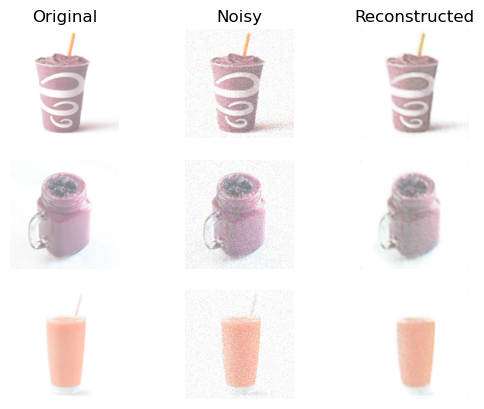

2024-03-03 07:33:01.008950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:01.787192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 201, Loss: 0.003280431730672717


2024-03-03 07:33:02.411208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:03.015891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 202, Loss: 0.0030346810817718506


2024-03-03 07:33:03.760095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:04.339872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 203, Loss: 0.0037071765400469303


2024-03-03 07:33:04.997647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:05.597541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 204, Loss: 0.0030432622879743576


2024-03-03 07:33:06.236960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:06.893322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 205, Loss: 0.0030229316325858235


2024-03-03 07:33:07.498808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:08.091883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 206, Loss: 0.003119592904113233


2024-03-03 07:33:08.658534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:09.211116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 207, Loss: 0.003146642935462296


2024-03-03 07:33:09.797607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:10.356003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 208, Loss: 0.0031844668556004763


2024-03-03 07:33:10.917883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:11.477845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 209, Loss: 0.0028130903374403715


2024-03-03 07:33:12.041049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:12.602984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 210, Loss: 0.003259827964939177
1/1 [==============================] - 0s 156ms/step


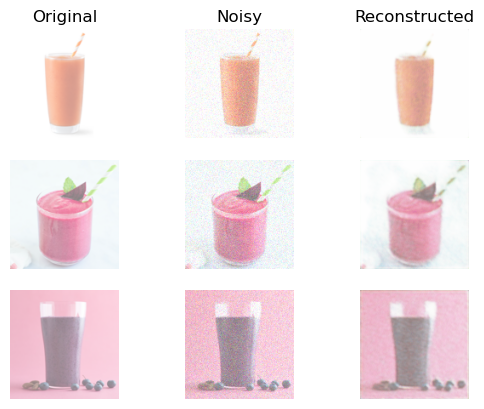

2024-03-03 07:33:13.482941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:14.068273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 211, Loss: 0.0034464355558156967


2024-03-03 07:33:14.661559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:15.225641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 212, Loss: 0.0031889196252450347


2024-03-03 07:33:15.786728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:16.363744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 213, Loss: 0.003188805072568357


2024-03-03 07:33:16.968709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:17.590083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 214, Loss: 0.003622374148108065


2024-03-03 07:33:18.199104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:18.763144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 215, Loss: 0.0028483569622039795


2024-03-03 07:33:19.327858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:19.944865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 216, Loss: 0.003023365163244307


2024-03-03 07:33:20.506403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:21.074824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 217, Loss: 0.0032218624837696552


2024-03-03 07:33:21.679653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:22.292343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 218, Loss: 0.0030434395885095


2024-03-03 07:33:22.895207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:23.473776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 219, Loss: 0.0026766773080453277


2024-03-03 07:33:24.066146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:24.633658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 220, Loss: 0.0032189590856432915
1/1 [==============================] - 0s 155ms/step


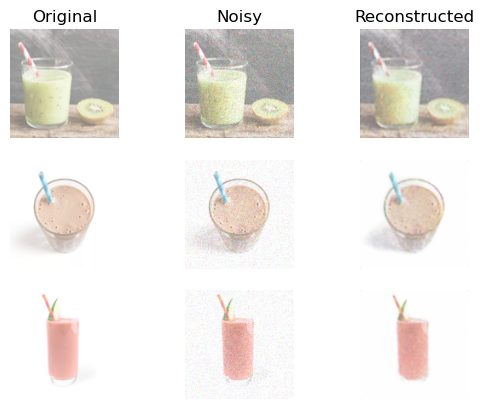

2024-03-03 07:33:25.511170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:26.084229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 221, Loss: 0.003207583911716938


2024-03-03 07:33:26.638952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:27.211786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 222, Loss: 0.0029502330580726266


2024-03-03 07:33:27.764683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:28.320434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 223, Loss: 0.003242235747165978


2024-03-03 07:33:28.881781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:29.437760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 224, Loss: 0.0026421271031722426


2024-03-03 07:33:30.008369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:30.706718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 225, Loss: 0.0032090804306790233


2024-03-03 07:33:31.285767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:31.858739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 226, Loss: 0.003350995830260217


2024-03-03 07:33:32.428516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:33.192811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 227, Loss: 0.0031700095860287547


2024-03-03 07:33:33.962796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:34.561860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 228, Loss: 0.003191126976162195


2024-03-03 07:33:35.170186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:35.991523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 229, Loss: 0.0029084174893796444


2024-03-03 07:33:36.628812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:37.248007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 230, Loss: 0.0029645137256011367
1/1 [==============================] - 0s 162ms/step


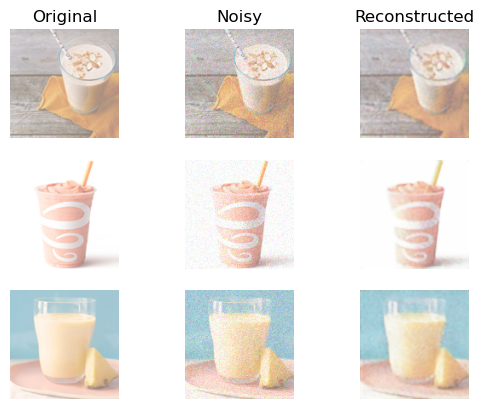

2024-03-03 07:33:38.183831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:38.788994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 231, Loss: 0.0029594629304483533


2024-03-03 07:33:39.374362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:39.947446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 232, Loss: 0.0028194868937134743


2024-03-03 07:33:40.518841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:41.076956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 233, Loss: 0.002625435241498053


2024-03-03 07:33:41.635511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:42.222214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 234, Loss: 0.0026029320433735847


2024-03-03 07:33:42.832873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:43.419617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 235, Loss: 0.0029485677368938923


2024-03-03 07:33:43.994909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:44.554682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 236, Loss: 0.0025770756183192134


2024-03-03 07:33:45.155575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:45.719922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 237, Loss: 0.0029095521895214915


2024-03-03 07:33:46.306119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:46.872513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 238, Loss: 0.0027297494234517217


2024-03-03 07:33:47.466182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:48.101240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 239, Loss: 0.0028257822850719094


2024-03-03 07:33:48.681871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:49.243624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 240, Loss: 0.0029235651018097997
1/1 [==============================] - 0s 156ms/step


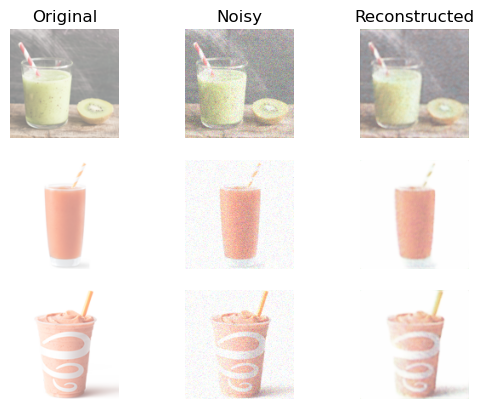

2024-03-03 07:33:50.325380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:50.915754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 241, Loss: 0.0026313429698348045


2024-03-03 07:33:51.472794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:52.035114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 242, Loss: 0.0030350293964147568


2024-03-03 07:33:52.605774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:53.200413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 243, Loss: 0.002858202438801527


2024-03-03 07:33:53.785884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:54.355330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 244, Loss: 0.002738798037171364


2024-03-03 07:33:54.937455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:55.663607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 245, Loss: 0.0022397981956601143


2024-03-03 07:33:56.431548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:57.041886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 246, Loss: 0.002760152448900044


2024-03-03 07:33:57.645755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:58.324398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 247, Loss: 0.002940230770036578


2024-03-03 07:33:58.946112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:33:59.529669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 248, Loss: 0.0028509675757959485


2024-03-03 07:34:00.135823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:00.788420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 249, Loss: 0.0032071410678327084


2024-03-03 07:34:01.387211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:01.986823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 250, Loss: 0.0027677312027662992
1/1 [==============================] - 0s 164ms/step


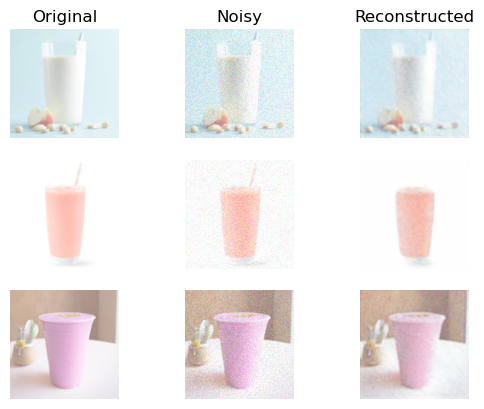

2024-03-03 07:34:02.941933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:03.515335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 251, Loss: 0.002545151044614613


2024-03-03 07:34:04.077668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:04.630483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 252, Loss: 0.0027038060361519456


2024-03-03 07:34:05.199815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:05.763432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 253, Loss: 0.0029142837738618255


2024-03-03 07:34:06.329471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:06.890307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 254, Loss: 0.0027623603818938136


2024-03-03 07:34:07.457392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:08.022128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 255, Loss: 0.002936192089691758


2024-03-03 07:34:08.591668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:09.215820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 256, Loss: 0.0027478550327941775


2024-03-03 07:34:09.786780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:10.360257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 257, Loss: 0.0025937712052837014


2024-03-03 07:34:10.934147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:11.666193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 258, Loss: 0.0023618520935997367


2024-03-03 07:34:12.428057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:13.032885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 259, Loss: 0.002872639801353216


2024-03-03 07:34:13.633745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:14.297398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 260, Loss: 0.0029144275467842817
1/1 [==============================] - 0s 161ms/step


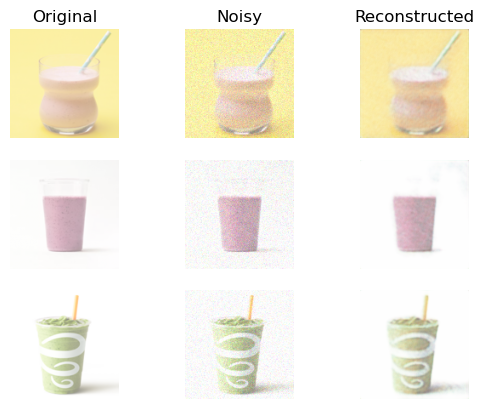

2024-03-03 07:34:15.259543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:15.897783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 261, Loss: 0.0025865118950605392


2024-03-03 07:34:16.516792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:17.214937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 262, Loss: 0.0025506651727482677


2024-03-03 07:34:17.782854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:18.392436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 263, Loss: 0.002553636906668544


2024-03-03 07:34:18.950035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:19.509857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 264, Loss: 0.0027225171215832233


2024-03-03 07:34:20.115170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:20.694959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 265, Loss: 0.002669680630788207


2024-03-03 07:34:21.282382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:21.877854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 266, Loss: 0.0028104131342843175


2024-03-03 07:34:22.453649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:23.018190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 267, Loss: 0.002416967647150159


2024-03-03 07:34:23.690161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:24.326584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 268, Loss: 0.00263273436576128


2024-03-03 07:34:25.052691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:25.634784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 269, Loss: 0.002539339824579656


2024-03-03 07:34:26.201883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:26.753462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 270, Loss: 0.002426627208478749
1/1 [==============================] - 0s 155ms/step


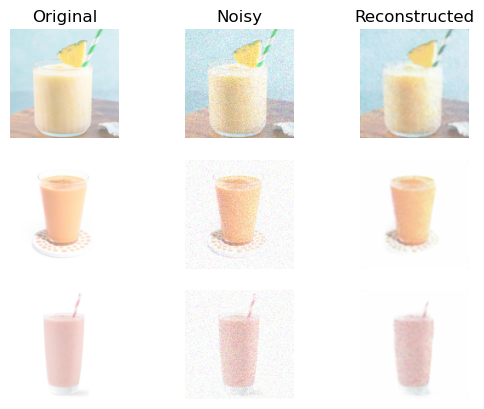

2024-03-03 07:34:27.631653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:28.216319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 271, Loss: 0.002576967584900558


2024-03-03 07:34:28.774842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:29.369953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 272, Loss: 0.002677519340068102


2024-03-03 07:34:30.001242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:30.625866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 273, Loss: 0.0028045366052538157


2024-03-03 07:34:31.224158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:31.837865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 274, Loss: 0.00258636218495667


2024-03-03 07:34:32.477712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:33.069546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 275, Loss: 0.0024397697998210788


2024-03-03 07:34:33.640013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:34.244547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 276, Loss: 0.0025414074771106243


2024-03-03 07:34:34.839081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:35.509116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 277, Loss: 0.0028740573907271028


2024-03-03 07:34:36.114539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:36.682518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 278, Loss: 0.002484680968336761


2024-03-03 07:34:37.250815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:37.853414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 279, Loss: 0.0025793277891352773


2024-03-03 07:34:38.504933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:39.080611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 280, Loss: 0.0023210763465613127
1/1 [==============================] - 0s 166ms/step


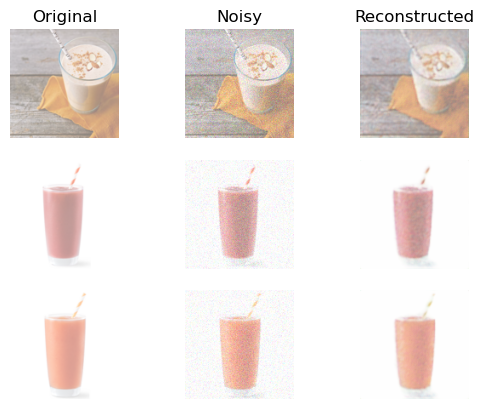

2024-03-03 07:34:40.013266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:40.625096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 281, Loss: 0.002639413462020457


2024-03-03 07:34:41.184175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:41.743762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 282, Loss: 0.0027907706098631024


2024-03-03 07:34:42.301117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:42.866672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 283, Loss: 0.0025980096543207765


2024-03-03 07:34:43.431608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:43.997823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 284, Loss: 0.002318726619705558


2024-03-03 07:34:44.563965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:45.121893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 285, Loss: 0.002724066493101418


2024-03-03 07:34:45.682804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:46.241826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 286, Loss: 0.0026703064795583487


2024-03-03 07:34:46.802821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:47.366701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 287, Loss: 0.002520812558941543


2024-03-03 07:34:47.931982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:48.506029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 288, Loss: 0.002496021566912532


2024-03-03 07:34:49.064932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:49.672008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 289, Loss: 0.002320418250747025


2024-03-03 07:34:50.271758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:50.851206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 290, Loss: 0.002488345024175942
1/1 [==============================] - 0s 158ms/step


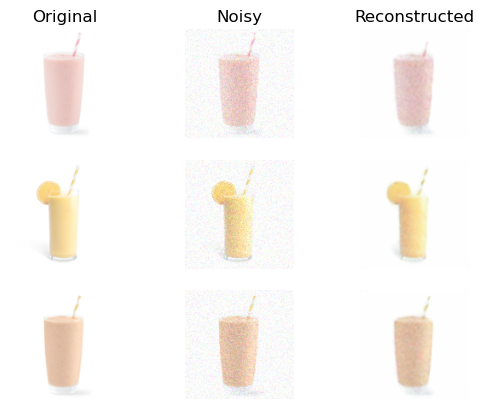

2024-03-03 07:34:51.783135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:52.366612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 291, Loss: 0.0026418077759444714


2024-03-03 07:34:52.989537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:53.590254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 292, Loss: 0.0024439888074994087


2024-03-03 07:34:54.379376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:55.108291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 293, Loss: 0.0023862532107159495


2024-03-03 07:34:55.733301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:56.381362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 294, Loss: 0.0024537191493436694


2024-03-03 07:34:57.046872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:57.652723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 295, Loss: 0.0026545742293819785


2024-03-03 07:34:58.266669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:34:58.851646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 296, Loss: 0.0023249988444149494


2024-03-03 07:34:59.445845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:35:00.059957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 297, Loss: 0.002777601475827396


2024-03-03 07:35:00.658303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:35:01.234251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 298, Loss: 0.0027250119019299746


2024-03-03 07:35:01.790776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:35:02.366533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 299, Loss: 0.0024095112457871437


2024-03-03 07:35:02.943202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 07:35:03.526842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 300, Loss: 0.0025873074773699045
1/1 [==============================] - 0s 173ms/step


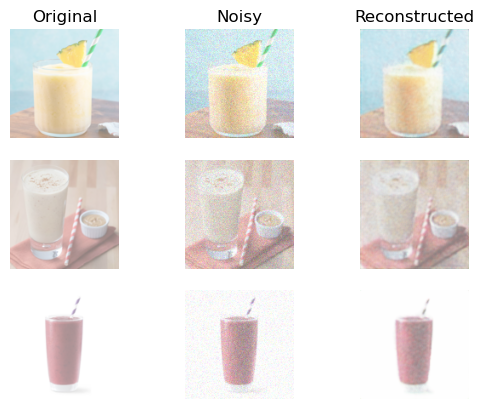

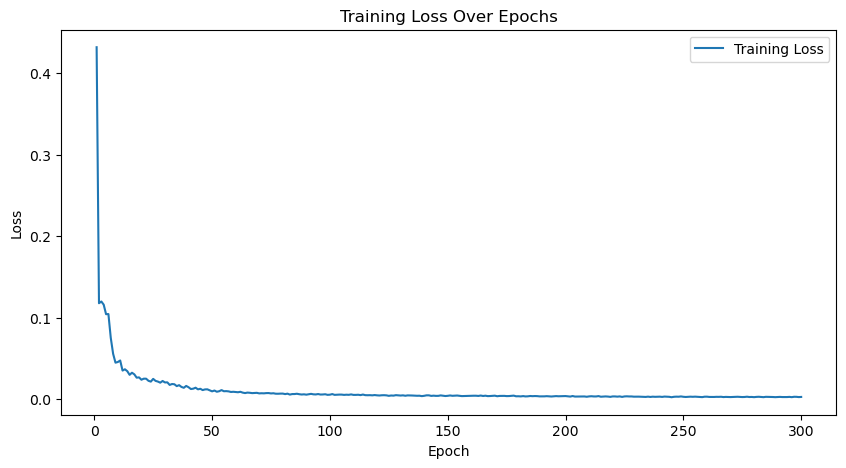

In [140]:
'''Training Execution'''
epochs = 300  # Set the number of epochs. Used to be 50
batch_size = 32  # Set the batch size. Used to be 32
steps_per_epoch = X_train.shape[0] // batch_size  # Assuming X_train is your dataset

# Placeholder for storing training loss
training_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    for step in range(steps_per_epoch):
        # Sample a batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # Apply the forward diffusion process (add noise)
        noisy_images = add_noise(real_images)
        
        # Train the model on this batch
        loss_value = model.train_on_batch(noisy_images, real_images)
        epoch_loss += loss_value
        
    # Calculate average loss for the epoch
    epoch_loss /= steps_per_epoch
    training_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Optionally display some reconstructed images at intervals
    if (epoch + 1) % 10 == 0:
        # Select a random batch of images
        test_idx = np.random.randint(0, X_train.shape[0], batch_size)
        test_images = X_train[test_idx]
        noisy_test_images = add_noise(test_images)
        reconstructed_images = model.predict(noisy_test_images)
        
        # Plot original, noisy, and reconstructed images
        for i in range(3):
            plt.subplot(3, 3, i*3 + 1)
            plt.imshow(test_images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            plt.subplot(3, 3, i*3 + 2)
            plt.imshow(noisy_test_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Noisy')
            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(reconstructed_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### Evaluation and Testing
- Generate images using the trained model and compare them to real images to assess quality.

This cell covers:
- Generating images by feeding noise to the trained model and running the reverse diffusion process.
- Displaying the generated images to visually evaluate how well the model has learned to generate smoothie images.
- Comparing with real images from the dataset for a direct quality assessment.

1/1 [==============================] - 0s 55ms/step


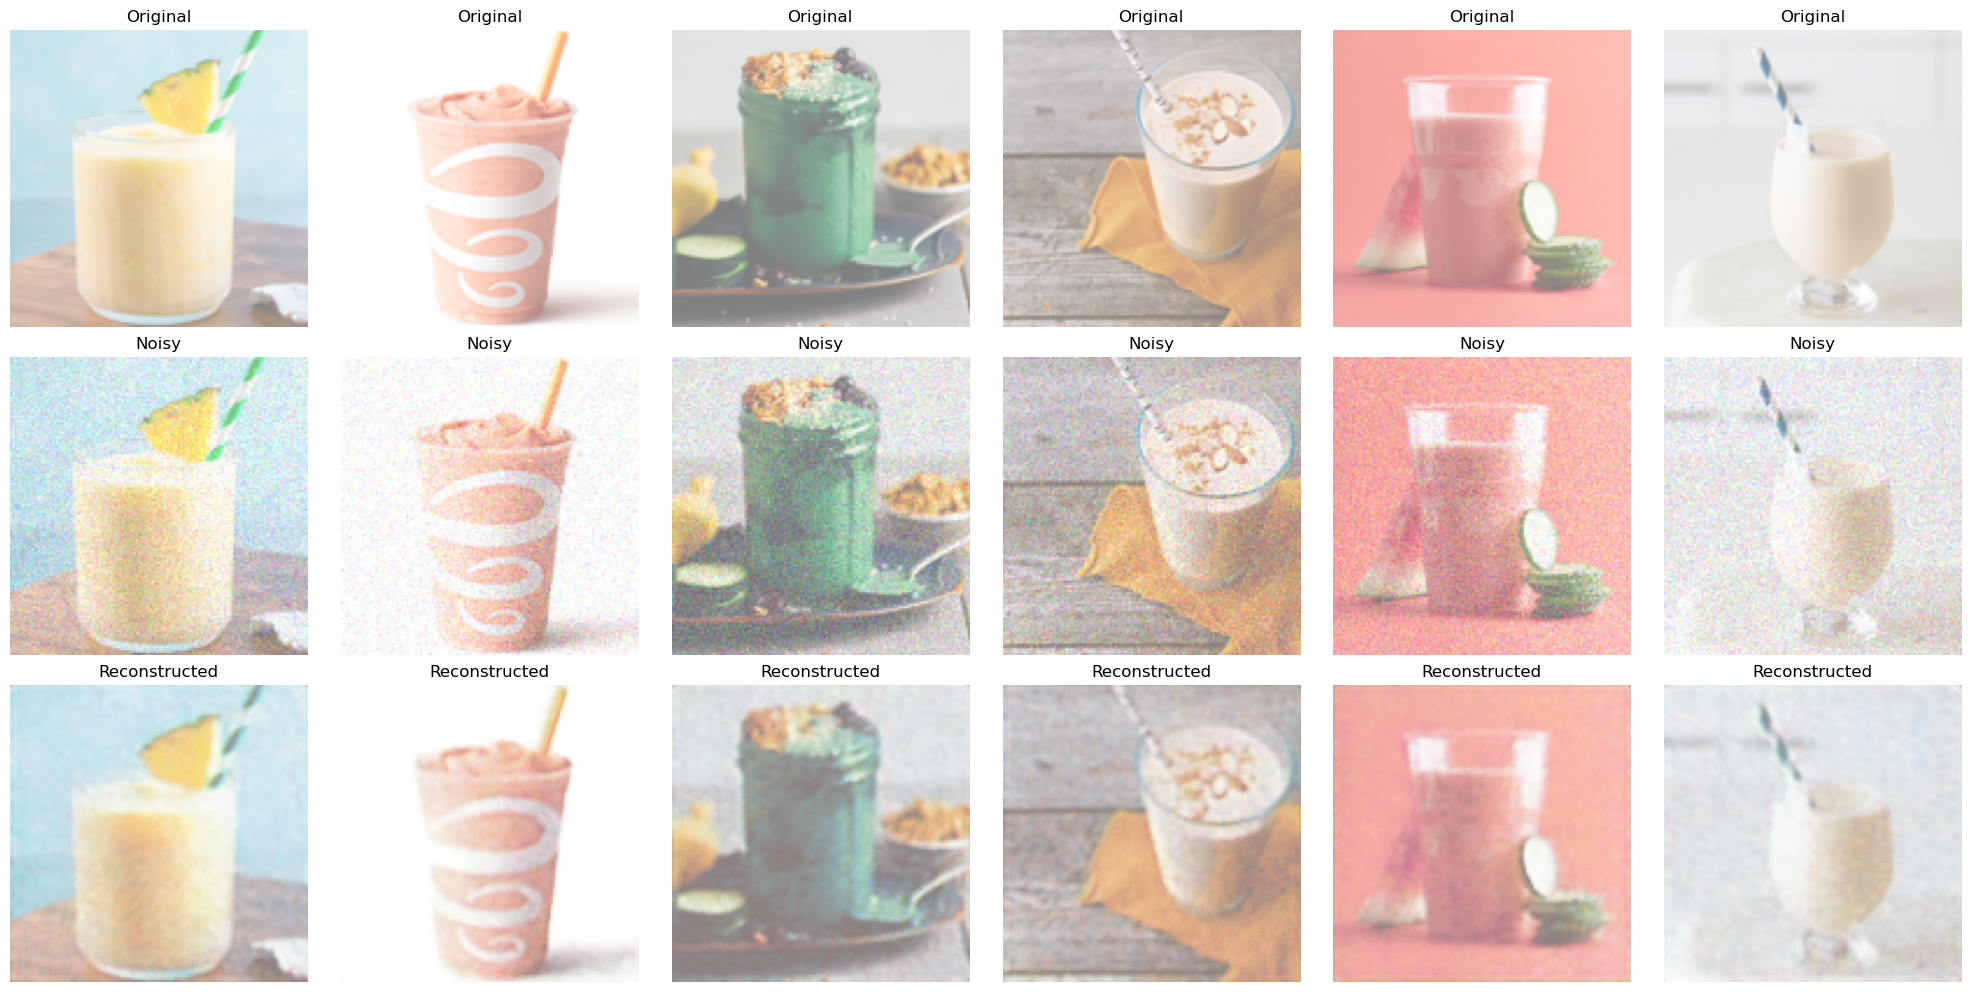

Average MSE between original and reconstructed images: 0.0031904604402788195


In [142]:
'''Evaluation and Testing'''
# Select a random batch of images
test_idx = np.random.randint(0, X_train.shape[0], 6)  # Adjust the number of images you want to test
test_images = X_train[test_idx]

# Apply noise
noisy_test_images = add_noise(test_images)

# Reconstruct the images using the trained model
reconstructed_images = model.predict(noisy_test_images)

# Display the original, noisy, and reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
for i in range(6):  # Adjust based on the number of test images
    # Original images
    axes[0, i].imshow(test_images[i] * 0.5 + 0.5)  # Adjust if your normalization is different
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Noisy images
    axes[1, i].imshow(noisy_test_images[i] * 0.5 + 0.5)  # Adjust if your normalization is different
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Reconstructed images
    axes[2, i].imshow(reconstructed_images[i] * 0.5 + 0.5)  # Adjust if your normalization is different
    axes[2, i].set_title("Reconstructed")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Assessing the quality
# Here you can include any quantitative metrics for assessment, such as MSE or SSIM, between original and reconstructed images.
# Example:
from sklearn.metrics import mean_squared_error

# Calculate MSE for each image in the batch and print the average
mse_scores = [mean_squared_error(test_images[i].flatten(), reconstructed_images[i].flatten()) for i in range(6)]
print(f"Average MSE between original and reconstructed images: {np.mean(mse_scores)}")



### Integration Instructions
- Outline how to integrate the model into your Flask application.

To integrate the trained model into your Flask application:
- Save the trained model.
- Load the model in your Flask application.
- Create an endpoint that receives ingredient information, generates a noise vector, and uses the model to generate a smoothie image.
- Return the generated image in response to the request.

In [ ]:
'''Integration Instructions'''
